In [1]:
import json
import cv2 as cv
import pickle as pkl
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt
import os, sys
import librosa

from scipy import stats, spatial, ndimage
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from Speech_Data_util import Sentence_word_phone_parser
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator
from prototypes.MVP.MVP_Aversion_saliency_list import Base_Static_Saliency_List
from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest, Scavenger_planner_simple 
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
from prototypes.MVP.MVP_gaze_path_planner import Responsive_planner_simple
import pickle
import math
from datetime import datetime, timezone
import scipy.stats as ss
from Signal_processing_utils import interpolate1D, runEuro
import numpy as np
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport prototypes.InputDataStructures
%aimport Signal_processing_utils
%aimport Speech_Data_util
%aimport prototypes.MVP.MVP_static_saliency_list
%aimport prototypes.EyeCatch.Saccade_model_with_internal_model
%aimport prototypes.InputDataStructures
%aimport prototypes.Jin2019.EyeHeadDecomposition
%aimport prototypes.Optimization_based_head_eye_seperator.Baseline_optimization
%aimport prototypes.Boccignone2020.Improved_gaze_target_planner
%aimport prototypes.MVP.MVP_gaze_path_planner
%aimport prototypes.JaliNeck.JaliNeck


In [3]:
# inputs
input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
# input_folder = "F:/MASC/Ribhav_processed_dataset/"
# input_file = "Stranger Things’ Dacre Montgomery’s Insane _Billy_ Audition Tape ｜ GQ"
input_file = "Madelaine Petsch audition for The Prom"

input_scene_data_path = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/simplest_scene.json"
speaker_id = 1
shot_id = 1
turn_taking_threshold = 2
fps = 24
np.random.seed(speaker_id + shot_id)


### Gather The transcript and Audio From Jali (because it's more reliable)

In [4]:

input_file_no_space = "_".join(input_file.split(" "))
# input_file_no_space = "'" + input_file_no_space + "'"
shot_file_name = os.path.join(os.path.join(os.path.join(input_folder, "shots"), input_file), "shot_cuts.json")
video_path = os.path.join(*[input_folder, "video", input_file+".mp4"])
audio_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 1))
audio_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 2))
script_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 1))
script_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 2))
praatoutput_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 1))
praatoutput_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 2))
head_direction_json_path = os.path.join(*[input_folder, "pose", input_file+".pkl"])
gaze_direction_json_path = os.path.join(*[input_folder, "L2CSNet", input_file+".json"])
landmarks_mediapipe_json_path = os.path.join(*[input_folder, "faces", input_file+" faces.pkl"])
python_out_location = os.path.join(*[input_folder, "outputs", input_file_no_space+".pkl"])
scene_file_out_location = os.path.join(*[input_folder, "annotated_scene", input_file+".json"])
animation_file_path = os.path.join(*[input_folder, "outputs", input_file+".json"])
# out_location = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"
# out_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"

sementic_script_1 = Sentence_word_phone_parser(praatoutput_1_path, script_1_path)
# sementic_script_1.get_turns(turn_taking_threshold)
sementic_script_2 = Sentence_word_phone_parser(praatoutput_2_path, script_2_path)
# sementic_script_2.get_turns(turn_taking_threshold)
audio_1, sr= librosa.load(audio_1_path, sr=44100)
audio_2, sr= librosa.load(audio_2_path, sr=44100)
agentScene1 = AgentInfo(scene_data_path)
agentScene2 = AgentInfo(scene_data_path)

NameError: name 'scene_data_path' is not defined

# Load video info (From annotation)

In [23]:
# load head angle data
all_head_data = pkl.load(open(head_direction_json_path, "rb"))
head_angle_data = all_head_data["HEAD"]
head_rotmat_per_frame = head_angle_data["ROTMAT"]
head_bbox_per_frame = all_head_data["BBOX"] # this is largely useless 
head_angle_per_frame = []
neutral_position = np.array([0, 0, 100])
for i in range(0, head_rotmat_per_frame.shape[0]):
    pos = head_rotmat_per_frame[i] @ neutral_position
    head_angle_per_frame.append(rotation_angles_frome_positions(pos[:]))
head_angle_per_frame = np.array(head_angle_per_frame)
# getting rotation angle in z direction
neutral_position2 = np.array([0, 100, 0])
head_angle_z_per_frame = []
for i in range(0, head_rotmat_per_frame.shape[0]):
    pos = head_rotmat_per_frame[i] @ neutral_position2
    pos = np.array([pos[1], pos[2], pos[0]])
    head_angle_z_per_frame.append(rotation_angles_frome_positions(pos)[1])
head_angle_xy_per_frame = np.array(head_angle_per_frame)
head_angle_z_per_frame = np.expand_dims(np.array(head_angle_z_per_frame), axis=1)
head_angle_per_frame = np.concatenate([head_angle_xy_per_frame, head_angle_z_per_frame], axis=1)

# load gaze data (L2CS)
all_gaze_data = pkl.load(open(gaze_direction_json_path, "rb"))
gaze_angle_data = all_gaze_data["RAW_GAZE"]
gaze_angle_per_frame = gaze_angle_data["EULER"]
gaze_rotmat_per_frame = gaze_angle_data["ROTMAT"]
blinks = all_head_data["BLINKS"]
gaze_vec = np.array([0, 0, 100])
eye_angle_per_frame = []
for i in range(0, gaze_rotmat_per_frame.shape[0]):
    eye_line = gaze_rotmat_per_frame[i] @ gaze_vec
    eye_line = eye_line / eye_line[2] * 100
    eye_angle_per_frame.append(eye_line)
eye_angle_per_frame = np.array(eye_angle_per_frame)
eye_angle_per_frame = rotation_angles_frome_positions(eye_angle_per_frame[:])

# time vector
ts = np.arange(0, eye_angle_per_frame.shape[0])/fps

## Smoothing the signal

In [24]:

smoothed_eye_angle_per_frame = runEuro(ts, eye_angle_per_frame, beta=0.007, min_cutoff=0.5)
gaze_speed = dx_dt(smoothed_eye_angle_per_frame)

smoothed_head_angle_per_frame = runEuro(ts, head_angle_xy_per_frame, beta=0.0, min_cutoff=1)
head_speed = dx_dt(smoothed_head_angle_per_frame)

## Playing around with clustering (Spoilers alert, it sucks)

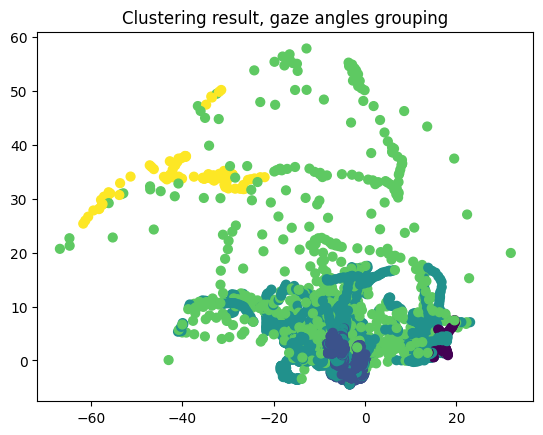

In [25]:
X = np.concatenate([smoothed_eye_angle_per_frame, smoothed_head_angle_per_frame, head_speed, gaze_speed], axis=1)
# Plot the data with K Means Labels
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
kmeans = GaussianMixture(5, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.title("Clustering result, gaze angles grouping")
X = smoothed_eye_angle_per_frame
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis'); 
plt.show()


## Dispersion based algorithm filtering (remove points that are not fixation as per the dispersion heuristic)

In [26]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)

    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixation_points = []
    fixation_frames = []
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            
        # if the current set of points never fit the duration criteria
        if len(window) == duration_threshold_frames:
            start = start + 1
        else:
            centroid = np.mean(y[window], axis=0)
            for w in window:
                fixation_points.append(centroid)
                fixation_frames.append(w)
    return np.array(fixation_frames), np.array(fixation_points)
fixation_frames, fixation_points = dispersion_filtering(ts, eye_angle_per_frame)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


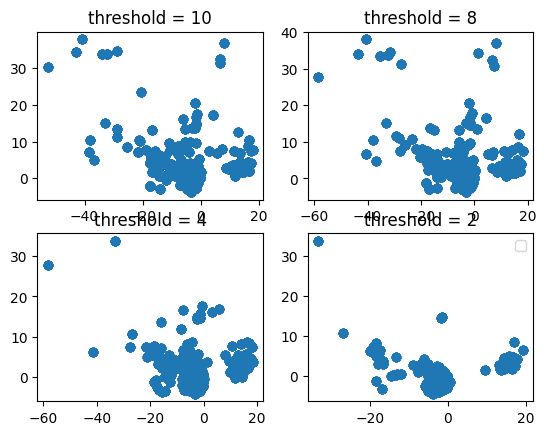

In [27]:
fixation_points = np.array(fixation_points)
thresholds = [10, 8, 4, 2] 
for i in range(0, 4):
    fixation_frames, fixation_points = dispersion_filtering(ts, eye_angle_per_frame, dispersion_threshold=thresholds[i])
    plt.subplot(2, 2, i+1)
    plt.title("threshold = {}".format(thresholds[i]))
    plt.scatter(fixation_points[:, 0], fixation_points[:, 1])
# plt.plot(fixation_points)
plt.legend()
plt.show()

## Dump the points into an arbituary file, which will then be read by the clustering interface (Clsuter_picker.py)

In [29]:
fixation_frames, fixation_points = dispersion_filtering(ts, eye_angle_per_frame, dispersion_threshold=8)
pkl.dump(fixation_points, open("./points.pkl", "wb"))

In [31]:
points = [[-4.370722100269148, 0.4746302855483897, 1] , 
[13.929040372039765, 3.888567164078202, -1] , 
[5.9282139887977365, 32.131135886461195, -1] , 
[-36.03356693607806, 34.05535485435981, -1] , 
[-39.267943559090796, 8.419792475581408, -1]]
points = np.array(points[:,0])

(5, 3)


# Load python output ()

In [11]:
output_json = pkl.load(open(python_out_location, "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/outputs/Madelaine_Petsch_audition_for_The_Prom.pkl'

In [ ]:
ek, hk, output_json

[[[[0.0, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.02, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.04, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.06, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.08, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.1, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.12, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.14, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.16, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.18, 15.460078239440918, -1.884105920791626, 128.16436767578125],
   [0.2, 18.684616088867188, -2.4230990409851074, 151.80076599121094],
   [0.22, 18.684616088867188, -2.4230990409851074, 151.80076599121094],
   [0.24, 18.684616088867188, -2.4230990409851074, 151.80076599121094],
   [0.26, 18.684616088867188, -2.4230990409851074, 151.80076599121094],
   [0